# **Case Datarisk - Score de Crédito**

## **Importa as bibliotecas e Carrega os Dados**

In [ ]:
import sys
import os

# Pega o diretório de trabalho atual (que é /notebooks)
notebook_dir = os.getcwd()
# Sobe um nível para o diretório raiz do projeto
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

# Adiciona a raiz do projeto ao sys.path se ainda não estiver lá
if project_root not in sys.path:
    print(f"Adicionando a raiz do projeto ao path: {project_root}")
    sys.path.append(project_root)

In [ ]:
from src.load_df import load_df
from src.convert_to_datetime import convert_to_datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

import requests
from pathlib import Path

from sklearn.metrics import roc_curve

In [13]:
# Carregar os DataFrames
df_cadastral = load_df("./data/base_cadastral.parquet")
df_emprestimos = load_df("./data/historico_emprestimos.parquet")
df_submissao = load_df("./data/base_submissao.parquet")
df_parcelas = load_df("./data/historico_parcelas_consolidado.parquet")
dicionario = load_df("./data/dicionario_dados.csv")

## **Converter Datas**

In [14]:
# listar as colunas que precisam de conversão em cada DataFrame
colunas_data_emprestimos = [
    'data_decisao',
    'data_liberacao',
    'data_primeiro_vencimento',
    'data_ultimo_vencimento_original',
    'data_ultimo_vencimento',
    'data_encerramento'
]

colunas_data_parcelas = [
    'data_prevista_pagamento',
    'data_real_pagamento'
]

colunas_data_cadastral = [
    'data_nascimento'
]

df_parcelas = convert_to_datetime(df_parcelas, colunas_data_parcelas)
df_emprestimos = convert_to_datetime(df_emprestimos, colunas_data_emprestimos)
df_cadastral = convert_to_datetime(df_cadastral, colunas_data_cadastral)


--- Verificando tipos de dados ANTES da conversão ---
data_prevista_pagamento    datetime64[ns]
data_real_pagamento        datetime64[ns]
dtype: object

--- Verificando tipos de dados DEPOIS da conversão ---
data_prevista_pagamento    datetime64[ns]
data_real_pagamento        datetime64[ns]
dtype: object

--- Verificando tipos de dados ANTES da conversão ---
data_decisao                       object
data_liberacao                     object
data_primeiro_vencimento           object
data_ultimo_vencimento_original    object
data_ultimo_vencimento             object
data_encerramento                  object
dtype: object

--- Verificando tipos de dados DEPOIS da conversão ---
data_decisao                       datetime64[ns]
data_liberacao                     datetime64[ns]
data_primeiro_vencimento           datetime64[ns]
data_ultimo_vencimento_original    datetime64[ns]
data_ultimo_vencimento             datetime64[ns]
data_encerramento                  datetime64[ns]
dtype: object

-

## **Explorar Target**


In [15]:
def display_target_proportion(target: pd.DataFrame):
  print(f"Distribuição da target:\n")
  display(target['inadimplente'].value_counts(normalize=True))

In [16]:
def criar_target(df_parcelas: pd.DataFrame, dias_atraso: int, mob: int, type: str = 'over'):
    """
    Cria uma variável target binária (0 ou 1) para cada contrato.

    A target será 1 se o cliente alguma vez (EVER) atrasou 'dias_atraso' ou mais
    em qualquer parcela dentro dos primeiros 'mob' meses (Month on Book) do contrato.

    Args:
        df_parcelas (pd.DataFrame): DataFrame com os dados das parcelas.
                                    Deve conter 'id_contrato', 'numero_parcela',
                                    'data_prevista_pagamento' e 'data_real_pagamento'.
        dias_atraso (int): O número de dias de atraso para considerar inadimplência (X).
        mob (int): A janela de observação em meses (Y).

    Returns:
        pd.DataFrame: Um DataFrame com 'id_contrato' e a coluna da nova target.
    """

    df = df_parcelas.copy()

    # calcula a diferença em dias
    df['dias_atraso'] = (df['data_real_pagamento'] - df['data_prevista_pagamento']).dt.days

    # O 'numero_parcela' é um proxy para o MOB
    if type == 'over':
        df_mob = df[df['numero_parcela'] == mob].copy()
    else:
        df_mob = df[df['numero_parcela'] <= mob].copy()

    # verificar se a condição de inadimplência foi atingida
    df_mob['inadimplente'] = (df_mob['dias_atraso'] >= dias_atraso).astype(int)

    # se o valor máximo de 'inadimplente' para um contrato for 1, ele atingiu a condição.
    target = df_mob.groupby('id_contrato')['inadimplente'].max().reset_index()
    return target

In [17]:
target_30_03 = criar_target(df_parcelas, dias_atraso=30, mob=3, type='ever')

display_target_proportion(target_30_03)

Distribuição da target:



inadimplente
0    0.996937
1    0.003063
Name: proportion, dtype: float64

In [18]:
df_parcelas_proc = df_parcelas.copy()

# define a data de referência como a última data de vencimento no dataset
data_mais_recente = df_parcelas_proc['data_prevista_pagamento'].max()
print(f"Data de referência (última parcela): {data_mais_recente.strftime('%Y-%m-%d')}")

# o limite de maturação agora é baseado na data mais recente dos dados
data_limite = data_mais_recente - pd.DateOffset(days=900)
df_parcelas_maturado = df_parcelas_proc[df_parcelas_proc['data_prevista_pagamento'] <= data_limite].copy()

# calcular DPD apenas para a base segura, sem usar fillna
df_parcelas_maturado['dias_atraso_calc'] = (df_parcelas_maturado['data_real_pagamento'] - df_parcelas_maturado['data_prevista_pagamento']).dt.days
df_parcelas_maturado.dropna(subset=['dias_atraso_calc'], inplace=True)
df_parcelas_maturado['dias_atraso_calc'] = df_parcelas_maturado['dias_atraso_calc'].clip(lower=0).astype(int)

Data de referência (última parcela): 2025-02-22


In [19]:
print(f'Número de parcelas após maturação: {len(df_parcelas_maturado)}')

Número de parcelas após maturação: 568491


In [20]:
# Pega o ID de todos os contratos que *em algum momento* tiveram 180+ dias de atraso
ids_inadimplentes_severos = set(
    df_parcelas_maturado[df_parcelas_maturado['dias_atraso_calc'] >= 180]['id_contrato'].unique()
)
print(f"Encontrados {len(ids_inadimplentes_severos)} contratos com atraso severo.")

Encontrados 511 contratos com atraso severo.


In [21]:
import itertools

def calcular_targets(df_parcelas, ids_inadimplentes_severos, dias_atraso_list, mob_list, target_type = 'ever'):
  # produto cartesiano para gerar todos os cenários
  cenarios = list(itertools.product(dias_atraso_list, mob_list))

  # calcular a taxa de default para cada cenário
  resultados = []
  for dias, mob in cenarios:
    target_df = criar_target(df_parcelas, dias_atraso=dias, mob=mob, type=target_type)

    inadimplentes_da_target = target_df[target_df['inadimplente'] == 1]

    denominador = len(inadimplentes_da_target)

    if denominador > 0:
        # Numerador: Desses inadimplentes, quantos estão na nossa lista de "prejuízo real"?
        ids_capturados = set(inadimplentes_da_target['id_contrato'])
        numerador = len(ids_capturados.intersection(ids_inadimplentes_severos))

        # Calcular a proporção (taxa de inadimplentes que chegaram a 180 dias de atraso)
        taxa_ever_180 = numerador / denominador
    else:
        taxa_ever_180 = 0 # Evita divisão por zero

    # Calculate taxa_default safely
    taxa_default = target_df['inadimplente'].value_counts(normalize=True)[1]

    resultados.append({'taxa_default': taxa_default, 'mob': mob, 'dias_atraso': dias, 'taxa_ever_180': taxa_ever_180})

  # Converter resultados para um DataFrame para facilitar a plotagem
  df_resultados = pd.DataFrame(resultados).sort_values('taxa_default', ascending=False)

  return df_resultados

In [22]:
total_contratos = df_emprestimos['id_contrato'].nunique()

mob_list = [x for x in range(3, 25, 3)]
dias_atraso_list = [x for x in range(15, 180, 5)]

df_resultados_ever = calcular_targets(df_parcelas, ids_inadimplentes_severos, dias_atraso_list, mob_list, target_type = 'ever')
df_resultados_over = calcular_targets(df_parcelas, ids_inadimplentes_severos, dias_atraso_list, mob_list, target_type = 'over')

Vamos comparar as targets.

Com o gráfico abaixo, fica nítido que o ponto de estabilidade está em 12 meses: a partir daí o default aumenta em uma taxa muito menor. Também observa-se a grande diferença entre o ever30 e o ever45, o que indica que muitos clientes que atrasaram 30 dias pagam antes dos 45 dias de atraso. Dessa forma, é interessante escolher um intervalo maior que 45 dias para o atraso, de forma a não penalizar clientes que são bons pagadores. Além disso, a diferença entre ever60 e ever90 é bem menor do que entre o ever45 e o ever60 (apesar de representar o dobro de tempo), assim, não há um ganho significativo em considerar o ever90, tendo em vista que uma grande parte das pessoas que atrasam 60 dias também atrasam 90.

Basenado-se nessa análise, vamos escolher a target como ever60mob12

In [23]:
def plot_target_comparison(df_resultados, mob_list):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    # Group by dias_atraso and plot lines for each group
    for dias in [15, 20, 30, 45, 60, 180]:
        df_subset = df_resultados[df_resultados['dias_atraso'] == dias]
        ax.plot(df_subset['mob'], df_subset['taxa_default'], marker='o', linestyle='-', label=f'{dias} dias de atraso')


    # Formatar o eixo Y como porcentagem
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))

    # Adicionar títulos e labels
    ax.set_title('Comparação de Taxas de Inadimplência para Diferentes Targets', fontsize=16, pad=20)
    ax.set_xlabel('MOB (meses)', fontsize=12)
    ax.set_ylabel('Taxa de Inadimplência (%)', fontsize=12)
    plt.xticks(mob_list) # Use the mob_list as ticks
    ax.legend(title='Dias de Atraso')
    plt.tight_layout()
    plt.show()

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    for mob in mob_list:
        df_subset = df_resultados[df_resultados['mob'] == mob].sort_values('dias_atraso')
        ax.plot(df_subset['dias_atraso'], df_subset['taxa_ever_180'], marker='o', markersize=4, linestyle='-', label=f'MOB {mob}')

    # Formatar eixos e títulos
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
    ax.set_title('Proporção de Inadimplentes (por Target) que Atingiram 180 Dias de Atraso', fontsize=16, pad=20)
    ax.set_xlabel('Critério de Atraso para Definição de Inadimplência (dias)', fontsize=12)
    ax.set_ylabel('Proporção que Atingiu 180 Dias (%)', fontsize=12)
    plt.xticks(dias_atraso_list, rotation=45, ha='right')
    ax.legend(title='Janela (MOB)')
    plt.tight_layout()
    plt.show()

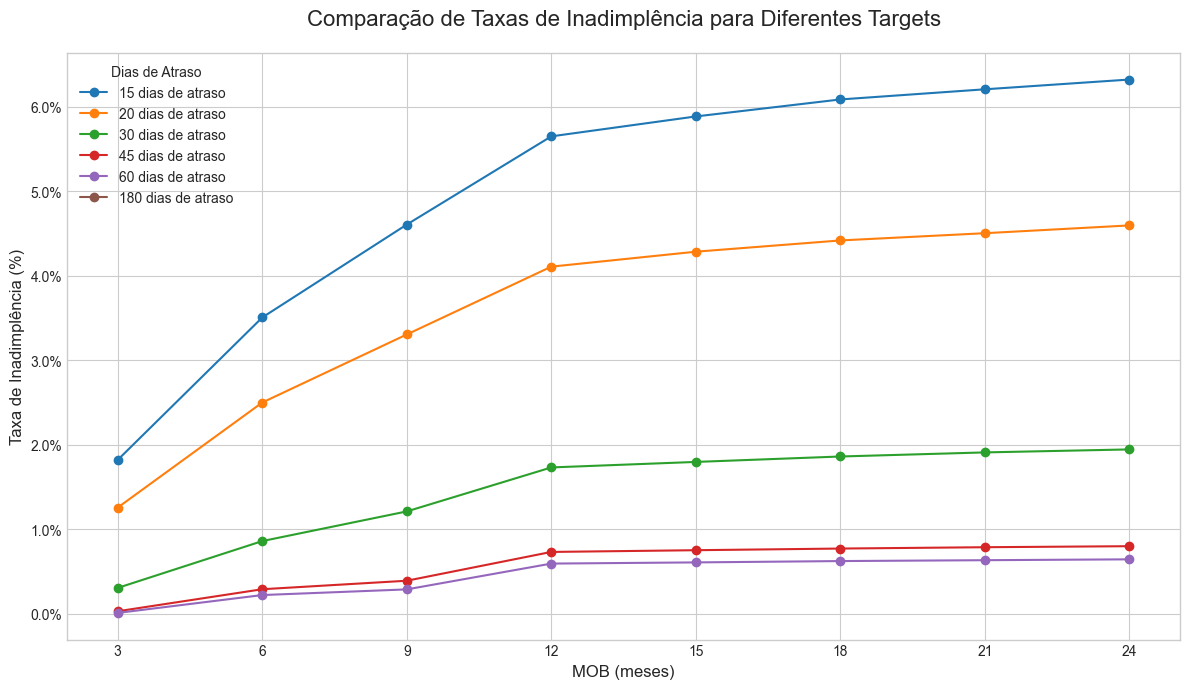

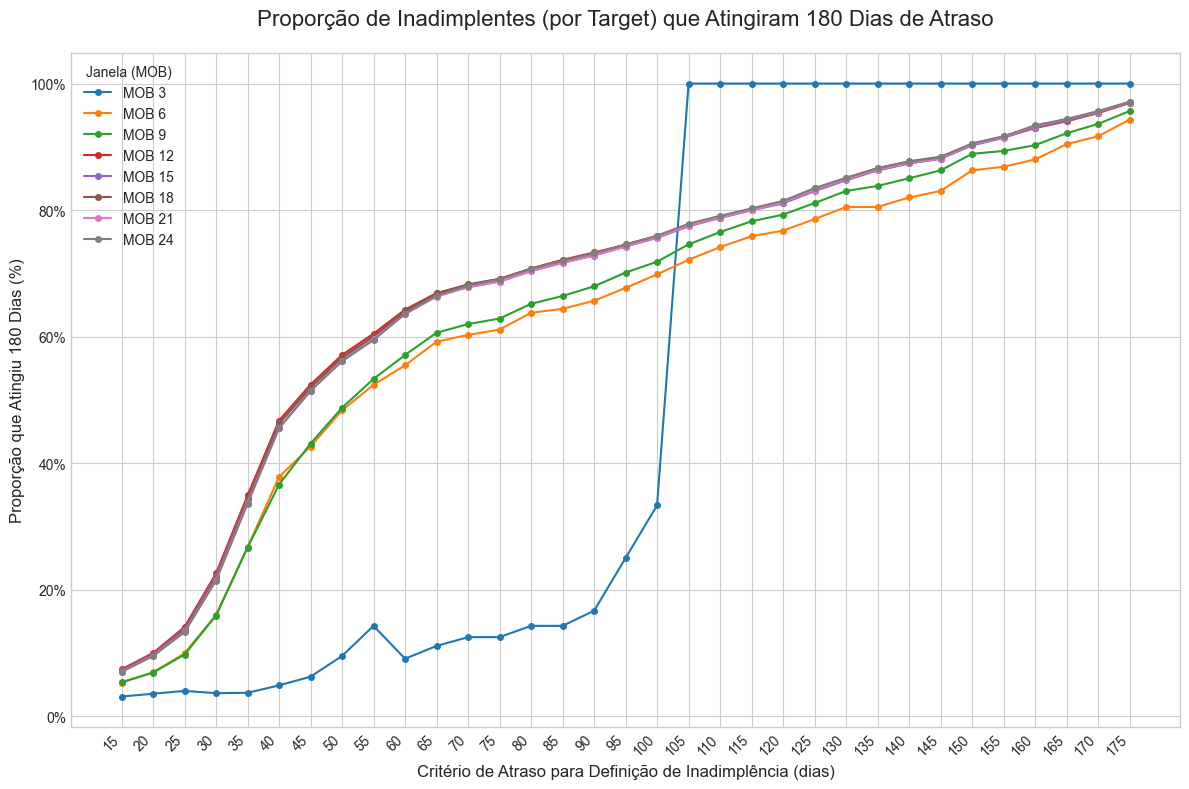

In [24]:
plot_target_comparison(df_resultados_ever, mob_list)

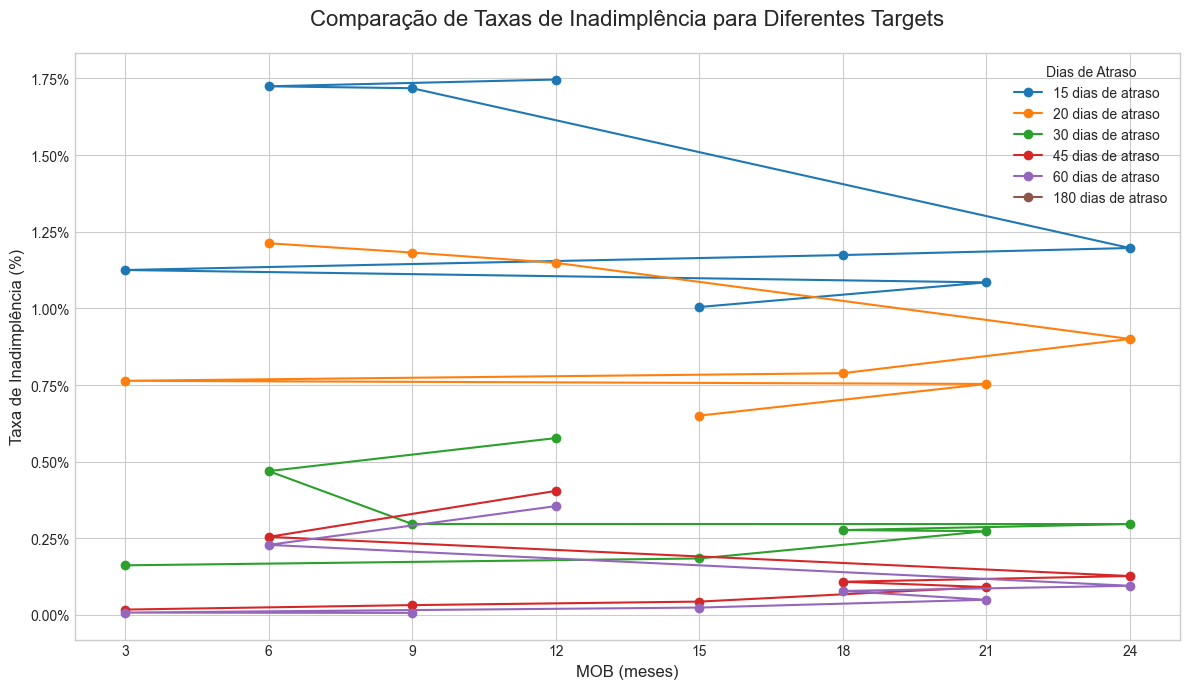

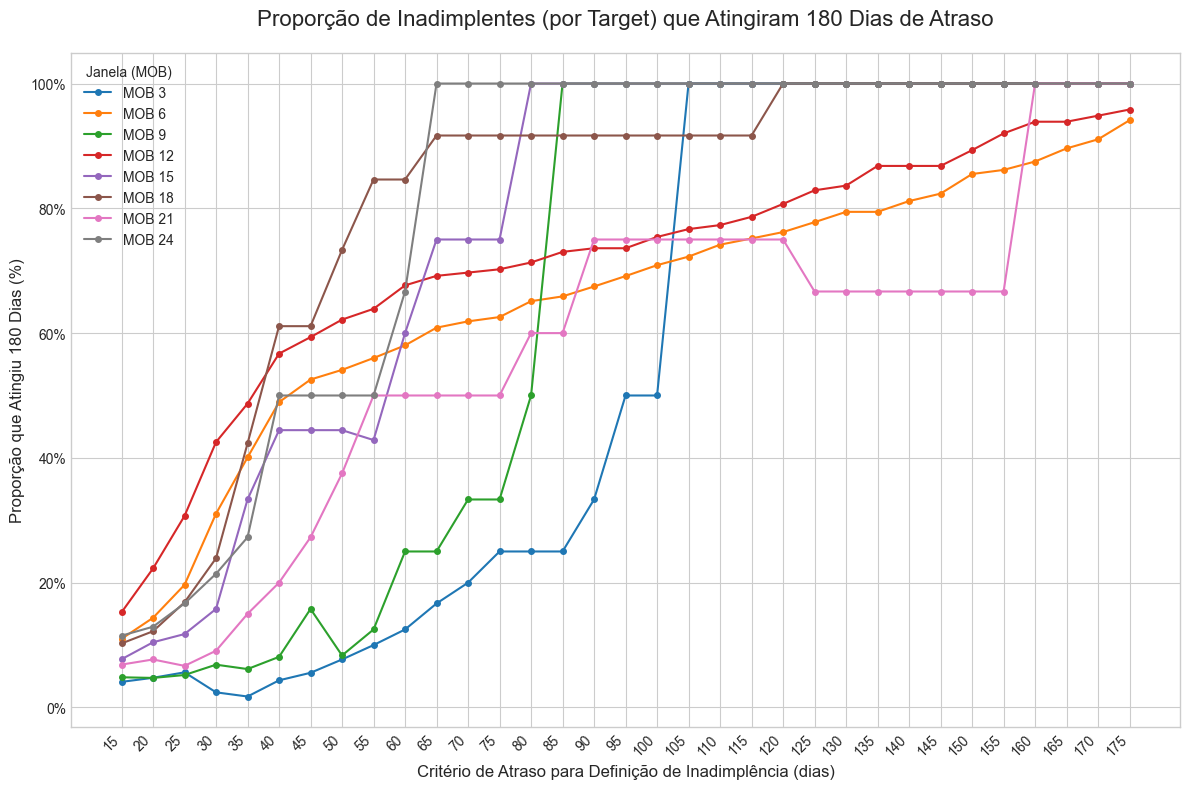

In [25]:
plot_target_comparison(df_resultados_over, mob_list)

### Salvar DataFrame com as Targets

In [26]:
targets = criar_target(df_parcelas, dias_atraso=20, mob=12, type='ever')
targets.to_parquet("./data/targets.parquet", index=False)

## **Funções Tonetti**

In [27]:
df_parcelas.head()

,id_contrato,numero_parcela,id_cliente,versao_parcela,data_prevista_pagamento,data_real_pagamento,valor_previsto_parcela,valor_pago_parcela
0,1000003,1,252457,1.0,2024-11-19,2024-11-05,4951.35,4951.35
1,1000003,2,252457,1.0,2024-12-19,2024-12-02,4951.35,4951.35
2,1000003,3,252457,1.0,2025-01-18,2025-01-03,4951.35,4951.35
3,1000013,1,215520,1.0,2021-05-23,2021-05-17,13347.90,13347.90
4,1000013,2,215520,1.0,2021-06-22,2021-06-16,13347.90,13347.90


In [28]:
def processa_over_target(df_filtro, df_target, janela, target_coluna):
    """
    Processa o target do tipo "over", que identifica se há parcelas em aberto dentro do período de corte.
    """

    # Identifica a última parcela de cada contrato
    ultimas_parcelas = df_filtro.groupby("id_contrato", as_index=False)["data_prevista_pagamento"].last()

    # Calcula a data de corte, que é a data de vencimento da última parcela mais a janela de tempo
    ultimas_parcelas['data_corte'] = ultimas_parcelas['data_prevista_pagamento'] + pd.DateOffset(days=janela)

    df_filtro = df_filtro.merge(ultimas_parcelas[['id_contrato', 'data_corte']], on='id_contrato', how='left')

    # Identifica contratos com parcelas não pagas ou pagas após a data de corte
    contratos_atrasados = df_filtro.loc[
        (df_filtro['data_real_pagamento'].isna()) |
        (df_filtro['data_real_pagamento'] > df_filtro['data_corte'])
    ]['id_contrato'].unique().tolist()

    df_target.loc[df_target["id_contrato"].isin(contratos_atrasados), target_coluna] = 1

def processa_ever_target(df_filtro, df_target, janela, target_coluna, data_atual):
    """
    Processa o target do tipo "ever", que identifica se houve qualquer atraso acima da janela de tempo
    """

    df_filtro['data_real_pagamento'] = df_filtro['data_real_pagamento'].fillna(data_atual)
    df_filtro['diff_pagamento'] = (df_filtro['data_real_pagamento'] - df_filtro['data_prevista_pagamento']).dt.days

    # Identifica contratos onde a diferença de pagamento excede a janela de dias
    contratos_atrasados = df_filtro.groupby(['id_contrato'], as_index=False)['diff_pagamento'].max().query(f"diff_pagamento > {janela}").id_contrato.tolist()

    df_target.loc[df_target["id_contrato"].isin(contratos_atrasados), target_coluna] = 1


In [29]:
def cria_target(df_spine, df_parcelas, janela, mob, tipo_target="over", data_atual=pd.to_datetime("2024-06-24")):
    """

    Parâmetros:
    - df_spine: DataFrame principal contendo os contratos.
    - df_parcelas: DataFrame contendo as parcelas dos contratos.
    - janela: Número de dias para definir atraso.
    - mob: Número de parcelas consideradas.
    - tipo_target: Tipo de target ("over" ou "ever").
    - data_atual: Data de referência.

    Retorno:
    - DataFrame df_target com a nova coluna de target.

    """

    # Ordena as parcelas por data de vencimento e contrato, e calcula o número da parcela
    df_parcelas = df_parcelas.sort_values(by=['data_prevista_pagamento', 'id_contrato']).reset_index(drop=True)
    df_parcelas['numero_parcela'] = df_parcelas.groupby("id_contrato").cumcount() + 1

    # Filtra as parcelas de acordo com a janela de tempo e o número máximo de parcelas (mob)
    df_filtro = df_parcelas.loc[
        (df_parcelas["numero_parcela"] <= mob) &
        (df_parcelas['data_prevista_pagamento'] <= data_atual - pd.DateOffset(days=janela))
    ].reset_index(drop=True)

    # Identifica os contratos válidos que têm exatamente o número de parcelas especificado por 'mob'
    ids_validos = (
        df_filtro.drop_duplicates(subset='id_contrato', keep='last')
        .query(f"numero_parcela == {mob}")
        .id_contrato
        .tolist()
    )


    df_filtro = df_filtro.loc[df_filtro['id_contrato'].isin(ids_validos)].reset_index(drop=True)

    target_coluna = f'{tipo_target}{janela}_mob0{mob}'
    df_target = df_filtro.drop_duplicates(subset='id_contrato')[['id_contrato']].reset_index(drop=True)
    df_target[target_coluna] = 0


    if tipo_target == "over":
        processa_over_target(df_filtro, df_target, janela, target_coluna)

    elif tipo_target == "ever":
        processa_ever_target(df_filtro, df_target, janela, target_coluna, data_atual)


    df_target = df_spine[['id_contrato', 'data_decisao']].merge(df_target, on='id_contrato', how='left')

    return df_target

In [30]:
def cria_lista_targets(df_spine, df_parcelas, lista_janelas = [], lista_mob = [], tipo_target="over",data_atual=pd.to_datetime("2024-06-24")):


    df_targets = df_spine.sort_values(by=['data_decisao','id_contrato']).reset_index(drop = True)

    for janela in lista_janelas:
        for mob in lista_mob:

            df_aux = cria_target(df_spine, df_parcelas, janela, mob, tipo_target, data_atual)
            df_targets = df_targets.merge(df_aux, on = ['id_contrato','data_decisao'], how = 'left')

    return df_targets

In [31]:
lista_janelas = np.arange(15,195, 15).tolist()
lista_mob = [1,2,3, 4, 5, 6]

df_targets_over = cria_lista_targets(df_emprestimos, df_parcelas, lista_janelas, lista_mob, "over")
df_targets_ever = cria_lista_targets(df_emprestimos, df_parcelas, lista_janelas, lista_mob, "ever")

In [32]:
df_targets_over.head()

,id_contrato,id_cliente,tipo_contrato,status_contrato,data_decisao,data_liberacao,data_primeiro_vencimento,data_ultimo_vencimento_original,data_ultimo_vencimento,data_encerramento,...,over165_mob03,over165_mob04,over165_mob05,over165_mob06,over180_mob01,over180_mob02,over180_mob03,over180_mob04,over180_mob05,over180_mob06
0,2474552,262196,Consumer loans,Approved,2017-02-04,NaT,2017-03-10,2017-10-06,2017-09-06,2017-11-12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1100313,436388,Revolving loans,Approved,2017-02-06,NaT,NaT,NaT,NaT,2024-11-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1137662,370786,Consumer loans,Approved,2017-02-07,NaT,2017-03-10,2017-08-07,2017-08-07,2023-07-23,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1424425,402457,Consumer loans,Approved,2017-02-07,NaT,2017-03-10,2017-06-08,2017-06-08,2017-06-25,...,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN
4,1567829,151305,Consumer loans,Approved,2017-02-07,NaT,2017-03-11,2017-06-09,2017-06-09,2017-09-24,...,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN


In [33]:
df_targets_ever.head()

,id_contrato,id_cliente,tipo_contrato,status_contrato,data_decisao,data_liberacao,data_primeiro_vencimento,data_ultimo_vencimento_original,data_ultimo_vencimento,data_encerramento,...,ever165_mob03,ever165_mob04,ever165_mob05,ever165_mob06,ever180_mob01,ever180_mob02,ever180_mob03,ever180_mob04,ever180_mob05,ever180_mob06
0,2474552,262196,Consumer loans,Approved,2017-02-04,NaT,2017-03-10,2017-10-06,2017-09-06,2017-11-12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1100313,436388,Revolving loans,Approved,2017-02-06,NaT,NaT,NaT,NaT,2024-11-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1137662,370786,Consumer loans,Approved,2017-02-07,NaT,2017-03-10,2017-08-07,2017-08-07,2023-07-23,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1424425,402457,Consumer loans,Approved,2017-02-07,NaT,2017-03-10,2017-06-08,2017-06-08,2017-06-25,...,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN
4,1567829,151305,Consumer loans,Approved,2017-02-07,NaT,2017-03-11,2017-06-09,2017-06-09,2017-09-24,...,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN


In [34]:
colunas_ever = [
    "ever15",
    "ever30",
    "ever45",
    "ever60",
    "ever75",
    "ever90",
    "ever105",
    "ever120",
    "ever135",
    "ever150",
    "ever165",
    "ever180",
]

colunas_mob01 = [x + "_mob01" for x in colunas_ever]
colunas_mob02 = [x + "_mob02" for x in colunas_ever]
colunas_mob03 = [x + "_mob03" for x in colunas_ever]
colunas_mob04 = [x + "_mob04" for x in colunas_ever]
colunas_mob05 = [x + "_mob05" for x in colunas_ever]
colunas_mob06 = [x + "_mob06" for x in colunas_ever]

colunas_mob_ever = [
    (colunas_mob01),
    (colunas_mob02),
    (colunas_mob03),
    (colunas_mob04),
    (colunas_mob05),
    (colunas_mob06),]

In [35]:
colunas_over = [
    "over15",
    "over30",
    "over45",
    "over60",
    "over75",
    "over90",
    "over105",
    "over120",
    "over135",
    "over150",
    "over165",
    "over180",
]

colunas_mob01 = [x + "_mob01" for x in colunas_over]
colunas_mob02 = [x + "_mob02" for x in colunas_over]
colunas_mob03 = [x + "_mob03" for x in colunas_over]
colunas_mob04 = [x + "_mob04" for x in colunas_over]
colunas_mob05 = [x + "_mob05" for x in colunas_over]
colunas_mob06 = [x + "_mob06" for x in colunas_over]

colunas_mob_over = [
    (colunas_mob01),
    (colunas_mob02),
    (colunas_mob03),
    (colunas_mob04),
    (colunas_mob05),
    (colunas_mob06),]

In [36]:
def razao_volume(df, colunas_mob):

    razao_moby = []
    volume = []
    volumetria = []


    for cada_mob in colunas_mob:

        # Máscara para filtrar apenas linhas com valores iguais a 0 ou 1
        mask = (df[cada_mob] > -1).all(axis=1)
        df_temp = df[mask][cada_mob]

        # Total de inadimplentes em todas as janelas de tempo
        total_inadimplentes = list(df_temp.sum().values)

        # 'if x > 0 else 0' para tratar a divisão por zero.
        # Se a contagem de inadimplentes (x) for 0, a razão também será 0.
        razao_calculada = [total_inadimplentes[-1] / x if x > 0 else 0 for x in total_inadimplentes]
        
        razao_moby.append(razao_calculada)

        volume.append(total_inadimplentes)
        volumetria.append(df_temp.shape[0])


    return razao_moby, volume, volumetria

In [37]:
x = ["15", "30", "45", "60", "75", "90","105", "120", "135", "150", "165", "180"]


def grafico_de_linhas(razao_moby, x, tipo_target):

    vetor_strings = ['mob01','mob02','mob03','mob04','mob05','mob06']

    # Gera dataframe do primeiro MOB
    axz = {f'% de {tipo_target}{x[-1]}': razao_moby[0], 'Dias de Atraso': x}
    df_mob = pd.DataFrame(axz)
    df_mob['MOB'] = vetor_strings[0]

    # Adiciona outros MOBs ao dataframe
    for i in range(1, len(vetor_strings)):
        axz = {f'% de {tipo_target}{x[-1]}': razao_moby[i], 'Dias de Atraso': x}
        df2 = pd.DataFrame(axz)
        df2['MOB'] = vetor_strings[i]
        df_mob = pd.concat([df_mob, df2],axis=0)

    sns.set_style('whitegrid')
    plt.figure(figsize=(12,6))
    ax = sns.lineplot(data = df_mob, x='Dias de Atraso',y=f'% de {tipo_target}{x[-1]}', hue='MOB', sort=False)
    plt.legend(loc=4, prop={'size': 13})
    plt.title(f"{tipo_target}")
    #plt.savefig("data/over120_linhas.png", bbox_inches="tight", dpi = 400)
    plt.show()

In [38]:
razao_moby, volume, volumetria = razao_volume(df_targets_over, colunas_mob_over)


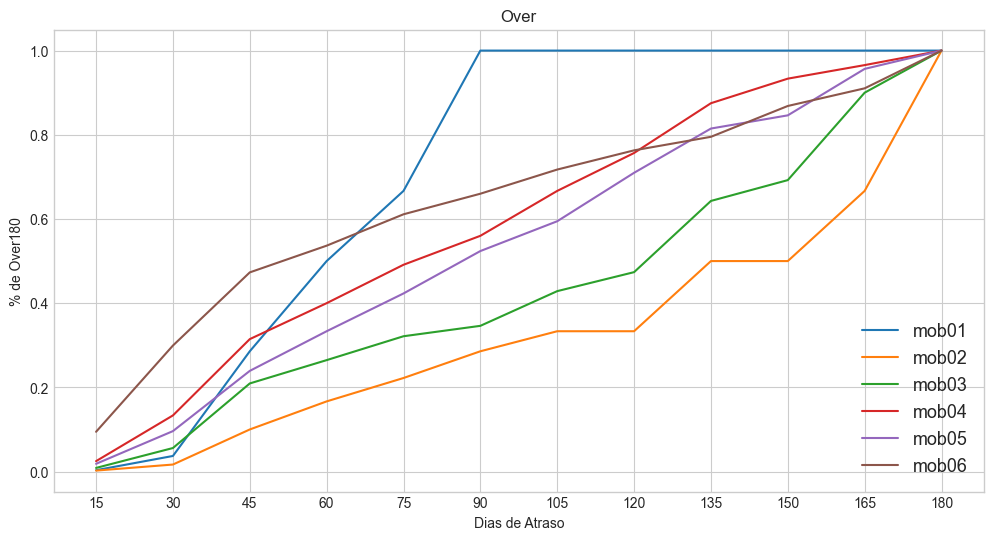

In [39]:
grafico_de_linhas(razao_moby, x, tipo_target = 'Over') 

In [40]:
def grafico_de_area_relativo(volume, x, colunas_mob, tipo_target):
    """
    Parâmetros:
    - volume: Lista de listas onde cada sublista contém volumes de inadimplentes para cada target.
    - x: Lista de valores de dias de atraso
    - colunas_mob: Lista de nomes das colunas MOBs que serão usadas no gráfico.

    Retorno:
    - Nenhum retorno. Exibe um gráfico de área empilhada.
    """

    # Configura o mapa de cores
    cmap = plt.cm.viridis
    n_mob = len(colunas_mob)

    # Gera a lista de cores usando o colormap
    color_list = [cmap(i / (n_mob - 1)) for i in range(n_mob)]

    # Calcula a diferença absoluta entre volumes de mobs sucessivos
    diferenca = [volume[0]]  # A primeira diferença é o volume inicial
    for i in range(1, len(volume)):
        diferenca.append([volume[i][j] - volume[i - 1][j] for j in range(len(volume[i]))])

    # Calcula a diferença relativa
    diferenca_relativa = [
        [diferenca[i][j] / volume[-1][j] for j in range(len(diferenca[i]))]
        for i in range(len(diferenca))
    ]
    vetor_strings = ["mob01", "mob02", "mob03", 'mob04', 'mob05', 'mob06']

    # Plotando o gráfico de área empilhada
    plt.figure(figsize=(16, 9))
    plt.stackplot(x, diferenca_relativa,labels=vetor_strings, colors=color_list)
    plt.legend(loc="upper right", prop={"size": 13}, bbox_to_anchor=(0.58, 0.45, 0.5, 0.5))
    plt.xlabel("Dias de Atraso")
    plt.ylabel("Proporção em cada Mob")
    plt.title(f"{tipo_target}")
    plt.show()

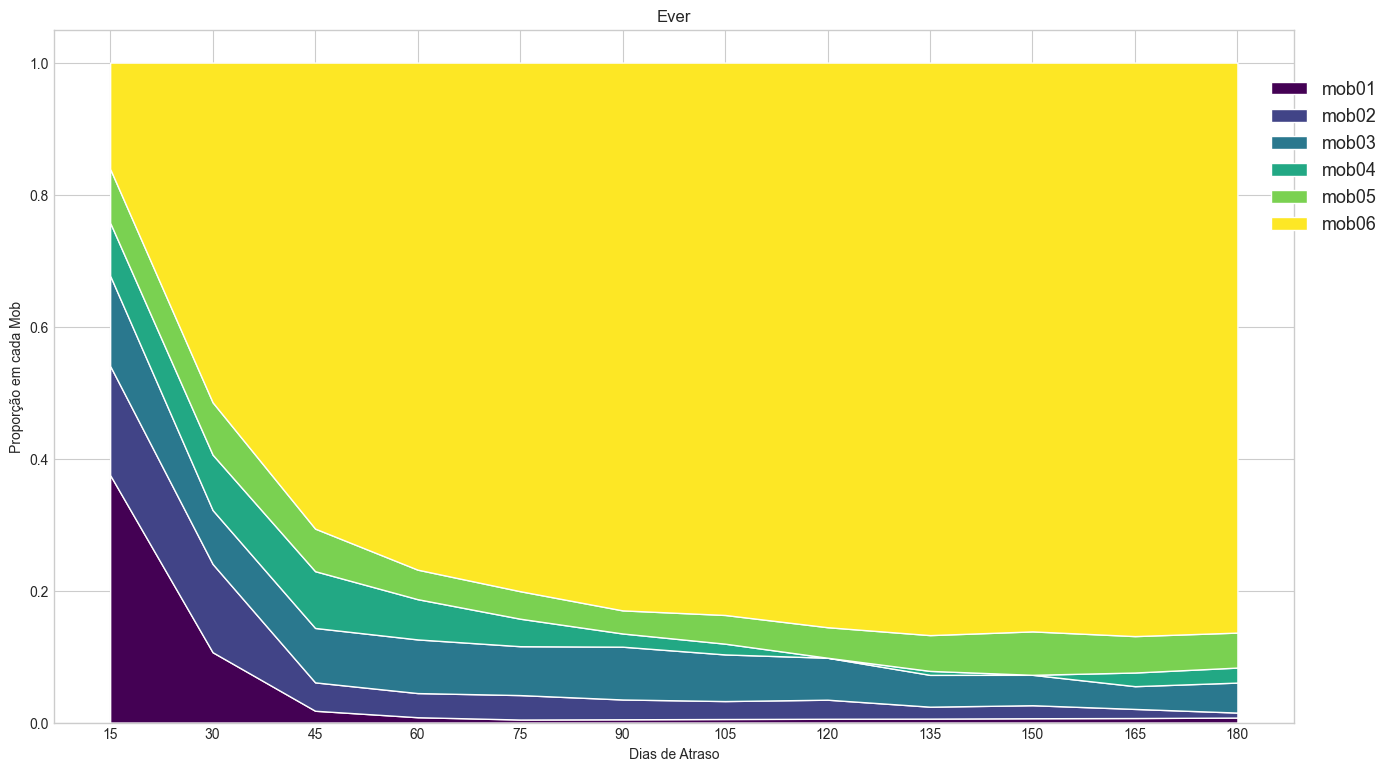

In [41]:
x = ["15", "30", "45", "60", "75", "90","105", "120", "135", "150", "165", "180"]
razao_moby1, volume1, volumetria = razao_volume(df_targets_over.loc[df_targets_over.iloc[:,-1].notna()], colunas_mob_over)
grafico_de_area_relativo(volume1, x, colunas_mob_over, "Ever")

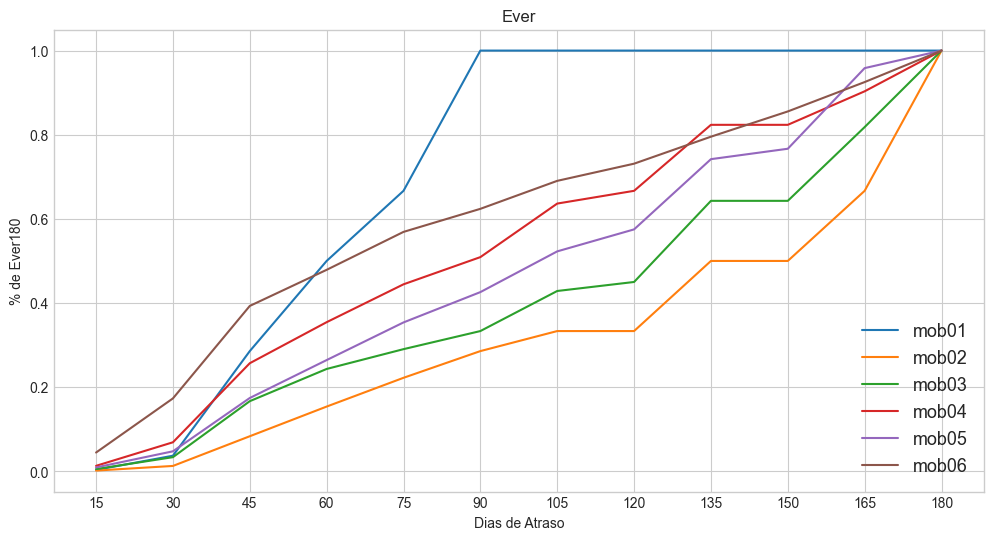

In [42]:
razao_moby, volume, volumetria = razao_volume(df_targets_ever, colunas_mob_ever)
grafico_de_linhas(razao_moby, x, tipo_target = 'Ever')

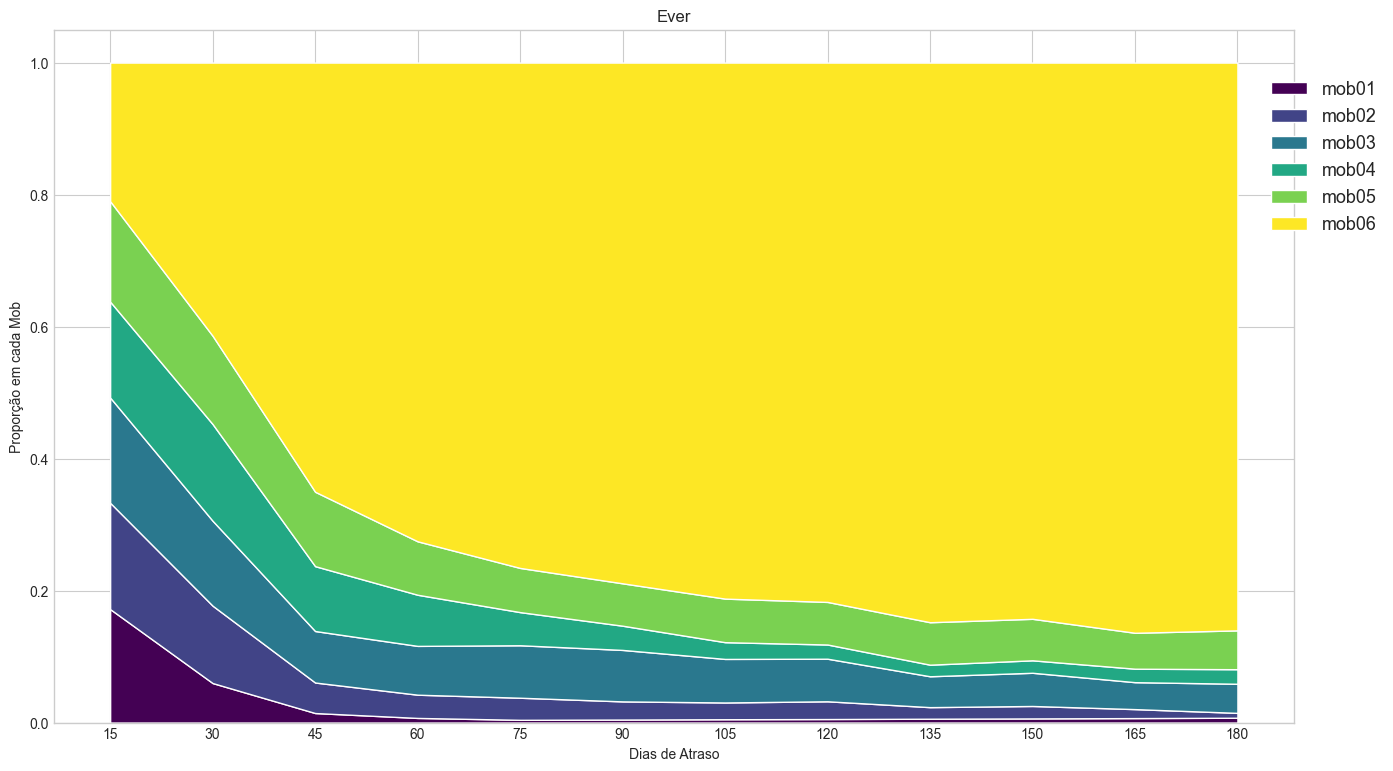

In [43]:
x = ["15", "30", "45", "60", "75", "90","105", "120", "135", "150", "165", "180"]
razao_moby1, volume1, volumetria = razao_volume(df_targets_ever.loc[df_targets_ever.iloc[:,-1].notna()], colunas_mob_ever)
grafico_de_area_relativo(volume1, x, colunas_mob_ever, "Ever")

In [44]:
import re

def show_matriz_migracao(df_targets, type = 'over', dias_atraso = 15):
    """
    Gera e exibe uma matriz de migração entre diferentes estados de MOBs
    para o target "over" com 15 dias de atraso.

    Parâmetros:
    - df_targets: DataFrame contendo as colunas de target.

    Retorno:
    - Nenhum retorno. Exibe um heatmap da matriz de migração.
    """
    # Seleciona colunas over15
    colunas_target = [c for c in df_targets.columns if re.match(fr'^{type}{dias_atraso}_mob\d+$', c)]

    # Garante que estão em ordem crescente (mob01, mob02, ...)
    colunas_target = sorted(colunas_target)

    # Cria uma matriz vazia para armazenar as transições
    matriz_transicao = pd.DataFrame(
        index=colunas_target,
        columns=colunas_target,
        dtype=float
    )

    # Calcula proporção de transição
    for i, origem in enumerate(colunas_target):
        origem_ativos = df_targets[origem] == 1  # contratos com 1 nesse MOB
        
        if origem_ativos.sum() == 0:
            continue  # evita divisão por zero
        
        for j, destino in enumerate(colunas_target):
            # Proporção de contratos que estavam 1 em origem e também 1 em destino
            proporcao = (df_targets.loc[origem_ativos, destino] == 1).mean()
            matriz_transicao.loc[origem, destino] = proporcao

    # Visualização
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        matriz_transicao,
        annot=True,
        fmt=".1%",
        cmap="Blues",
        linewidths=0.5,
        linecolor="lightgrey"
    )

    plt.title(f"Matriz de Migração entre MOBs ({type.capitalize()} {dias_atraso} Dias)", fontsize=14)
    plt.xlabel("Estado Final (MOB destino)")
    plt.ylabel("Estado Inicial (MOB origem)")
    plt.yticks(rotation=0)
    plt.show()


In [45]:
df_targets_ever.head()

,id_contrato,id_cliente,tipo_contrato,status_contrato,data_decisao,data_liberacao,data_primeiro_vencimento,data_ultimo_vencimento_original,data_ultimo_vencimento,data_encerramento,...,ever165_mob03,ever165_mob04,ever165_mob05,ever165_mob06,ever180_mob01,ever180_mob02,ever180_mob03,ever180_mob04,ever180_mob05,ever180_mob06
0,2474552,262196,Consumer loans,Approved,2017-02-04,NaT,2017-03-10,2017-10-06,2017-09-06,2017-11-12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1100313,436388,Revolving loans,Approved,2017-02-06,NaT,NaT,NaT,NaT,2024-11-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1137662,370786,Consumer loans,Approved,2017-02-07,NaT,2017-03-10,2017-08-07,2017-08-07,2023-07-23,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1424425,402457,Consumer loans,Approved,2017-02-07,NaT,2017-03-10,2017-06-08,2017-06-08,2017-06-25,...,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN
4,1567829,151305,Consumer loans,Approved,2017-02-07,NaT,2017-03-11,2017-06-09,2017-06-09,2017-09-24,...,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN


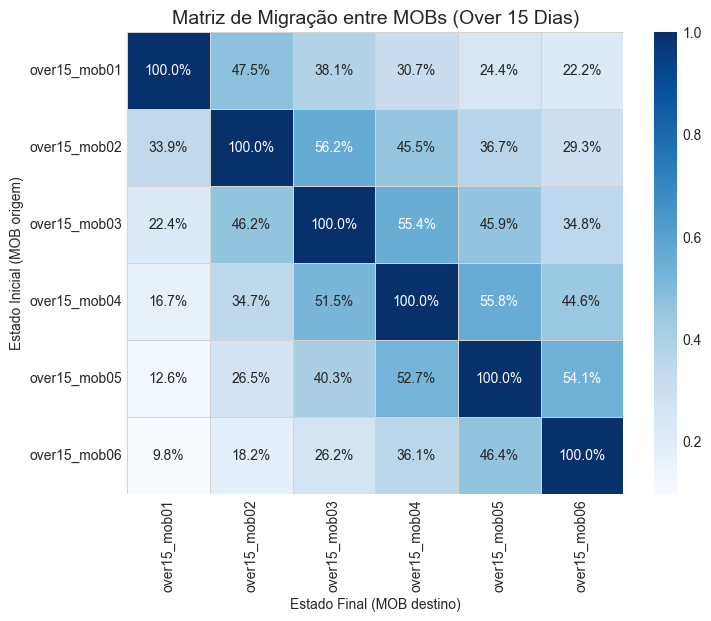

In [46]:
show_matriz_migracao(df_targets_over, type='over', dias_atraso=15)

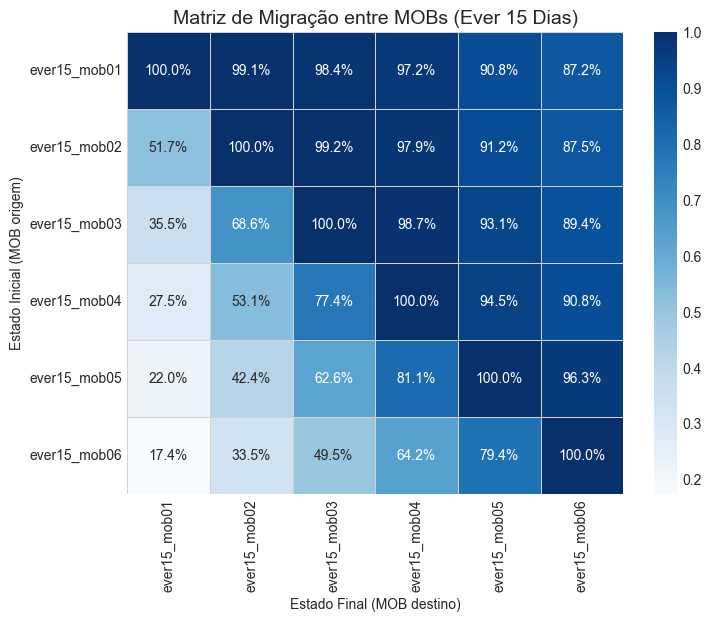

In [47]:
show_matriz_migracao(df_targets_ever, type='ever', dias_atraso=15)

In [48]:
df_targets = df_targets_over.rename(columns={'over15_mob06': 'inadimplente'})
df_targets = df_targets[['id_contrato', 'inadimplente']]
df_targets.dropna(subset=['inadimplente'], inplace=True)

In [50]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71043 entries, 0 to 138840
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_contrato   71043 non-null  int64  
 1   inadimplente  71043 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.6 MB


In [49]:
df_targets.to_parquet("./data/targets.parquet", index=False)